In [1]:
from pathlib import Path
import json
from tnia.deeplearning.dl_helper import collect_training_data
from tnia.plotting.plt_helper import imshow_multi2d

In [2]:

tnia_images_path = Path("D:/images")
parent_path=Path(tnia_images_path / r'D:\images\tnia-python-images\imagesc\2024_09_25_Intanseg_bees')
#test_name='bsp1-2.jpg'
n_rays = 32

In [3]:

train_path = parent_path / 'patches'

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

label_patch_path = train_path / 'ground truth0'
image_patch_path = train_path / 'input0'

model_path = parent_path / 'model'



sub_sample 1
axes YXC


In [4]:
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

type X  <class 'list'>
type Y  <class 'list'>


(256, 256, 3) (256, 256)
0.031147929 0.5207656


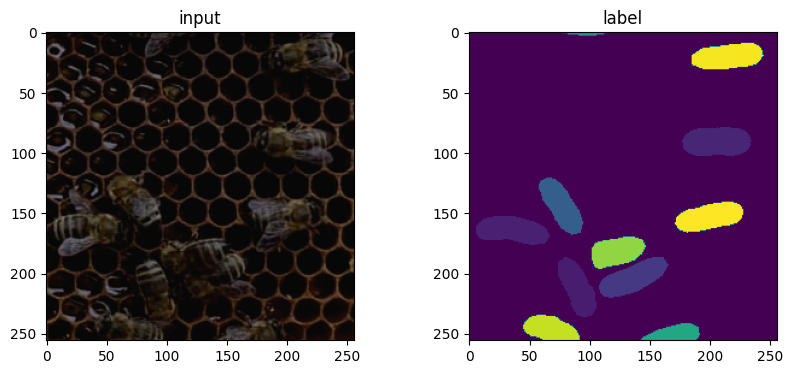

In [5]:
n=35
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [6]:
import argparse
import torch

parser = argparse.ArgumentParser([])

#basic usage
parser.add_argument("-d_p", "--data_path", type=str, default=r"../datasets", help="Path to the .pth file")
parser.add_argument("-data", "--dataset", type=str, default="segmentation", help="Name of the dataset to load")
parser.add_argument('-source', '--source_dataset', default="all", type=str, help = "Which datasets to use for training. Input is 'all' or a list of datasets (e.g. [TNBC_2018,LyNSeC,IHC_TMA,CoNSeP])")
parser.add_argument("-m_f", "--model_folder", type=str, default=None, help = "Name of the model to resume training. This must be a folder inside model_path")
parser.add_argument("-m_p", "--model_path", type=str, default=r"../models", help = "Path to the folder containing the models")
parser.add_argument("-o_p", "--output_path", type=str, default=r"../models", help = "Path to the folder where the results will be saved")
parser.add_argument("-e_s", "--experiment_str", type=str, default="my_first_instanSeg", help = "String to identify the experiment")
parser.add_argument("-d", "--device", type=str, default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
parser.add_argument('-num_workers', '--num_workers', default=3, type=int, help = "Number of CPU cores to use for data loading")
parser.add_argument('-ci', '--channel_invariant', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to add a channel invariant model to the pipeline")
parser.add_argument('-target', '--target_segmentation', default="N",type=str, help = " Cells or nuclei or both? Accepts: C,N, NC")  
parser.add_argument('-pixel_size', '--requested_pixel_size', default=None, type=float, help = "Requested pixel size to rescale the input images")


#advanced usage
parser.add_argument("-bs", "--batch_size", type=int, default=3)
parser.add_argument("-e", "--num_epochs", type=int, default=500)
parser.add_argument('-len_epoch', '--length_of_epoch', default=1000, type=int, help = "Number of samples per epoch")
parser.add_argument("-lr", "--lr", type=float, default=0.001, help = "Learning rate")
parser.add_argument("-m", "--model_str", type=str, default="InstanSeg_UNet", help = "Model backbone to use")
parser.add_argument("-s", "--save", type=bool, default=True, help = "Whether to save model outputs every time a new best F1 score is achieved")
parser.add_argument("-l_fn", "--loss_function", type=str, default='instanseg_loss', help = "Method to use for segmentation, only instanseg_loss is supported")
parser.add_argument("-n_sigma", "--n_sigma", type=int, default=2, help = "Number of sigma channels, must be at least 1")
parser.add_argument("-cluster", "--on_cluster", type=bool, default=False, help ="Flag to disable tqdm progress bars and other non-essential outputs, useful for running on a cluster")
parser.add_argument("-w", "--weight", default=False, type = lambda x: (str(x).lower() == 'true'), help = "Weight the random sampler in the training set to oversample images with more instances")
parser.add_argument("-layers", "--layers", type=str, default="[32, 64, 128, 256]", help = "UNet layers")
parser.add_argument("-slice", "--data_slice", type=int, default=None, help = "Slice of the dataset to use, useful for debugging (e.g. only train on 1 image)")
parser.add_argument("-clip", "--clip", type=float, default=20, help ="Gradient clipping value")
parser.add_argument("-decay", "--weight_decay", type=float, default=0.000, help = "Weight decay")
parser.add_argument("-drop", "--dropprob", type=float, default=0., help = "Dropout probability, Not implemented for InstanSeg_UNet")
parser.add_argument("-tf", "--transform_intensity", type=float, default=0.5, help = "Intensity transformation factor")
parser.add_argument("-dim_in", "--dim_in", type=int, default=3,help="Number of channels that the (backbone) model expects. This is also the number of channels a channel invariant model would output.")
parser.add_argument("-dummy", "--dummy", default=False, type=lambda x: (str(x).lower() == 'true'),help="Use the training set as a validation set, this will trigger a warning message. use only for debugging")
parser.add_argument('-to_centre', '--to_centre', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to use the instance centroid or the learnt instance centroid in InstanSeg")
parser.add_argument('-multi_centre', '--multi_centre', default=True, type=lambda x: (str(x).lower() == 'true'), help = "Allow multi centres per instance, uses local maxima algorithm")
parser.add_argument('-open_license', '--open_license', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to filter out images that do not have an open license during training")
parser.add_argument('-modality', '--image_modality', default="all", type=str, help = "Filter out images that do not have this modality: Brightfield, Fluorescence, all")
parser.add_argument('-binary_loss_fn', '--binary_loss_fn', default="lovasz_hinge", type=str, help = "Loss function to use for instance segmentation: lovasz_hinge or dice_loss are supported. lovasz_hinge is a lot slower to start converging")
parser.add_argument('-seed_loss_fn', '--seed_loss_fn', default="l1_distance", type=str, help = "Loss function to use for seed selection, only binary_xloss and l1_distance are supported. Binary_xloss is much faster, but l1_distance is usually more accurate")
parser.add_argument('-anneal', '--cosineannealing', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to use cosine annealing for the learning rate")
parser.add_argument('-o_h', '--optimize_hyperparameters', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to optimize hyperparameters every 10 epochs")
parser.add_argument('-hotstart', '--hotstart_training', default=10, type=int, help = "Number of epochs to train the model with binary_xloss before starting the main training loop (default=10)")
parser.add_argument('-window', '--window_size', default=128, type=int, help = "Size of the window containing each instance")
parser.add_argument('-multihead', '--multihead', default= True, type=lambda x: (str(x).lower() == 'true'), help = "Whether to branch the decoder into multiple heads.")
parser.add_argument('-dim_coords', '--dim_coords', default=2, type=int, help = "Dimensionality of the coordinate system. Little support for anything but 2")
parser.add_argument('-norm', '--norm', default="BATCH", type=str, help = "Norm layer to use: None, INSTANCE, INSTANCE_INVARIANT, BATCH")
parser.add_argument('-mlp_w', '--mlp_width', default=5, type=int, help = "Width of the MLP hidden dim")
parser.add_argument('-feature_engineering', '--feature_engineering', default="0", type=str, help = "Feature engineering function to use")
parser.add_argument('-augmentation_type', '--augmentation_type', default="minimal", type=str, help = "'minimal' or 'heavy' or 'brightfield_only'")
parser.add_argument('-adaptor_net', '--adaptor_net_str', default="0", type=str, help = "Adaptor net to use")

parser.add_argument('-rng_seed', '--rng_seed', default=None, type=int, help = "Optional seed for the random number generator")
parser.add_argument('-use_deterministic', '--use_deterministic', default=False, type=lambda x: (str(x).lower() == 'true'), help = "Whether to use deterministic algorithms (default=False)")

_StoreAction(option_strings=['-use_deterministic', '--use_deterministic'], dest='use_deterministic', nargs=None, const=None, default=False, type=<function <lambda> at 0x0000018194B69AB0>, choices=None, required=False, help='Whether to use deterministic algorithms (default=False)', metavar=None)

In [7]:
args = parser.parse_args([])
args.feature_engineering

'0'

In [8]:

from InstanSeg.utils.utils import plot_average, _choose_device
from InstanSeg.utils.AI_utils import optimize_hyperparameters, train_epoch, test_epoch
from InstanSeg.utils.model_loader import build_model_from_dict, load_model_weights
from InstanSeg.utils.data_loader import _read_images_from_pth, get_loaders

import torch.optim as optim

args = parser.parse_args([])


args.data_path = Path(args.data_path)

# Seed as many rngs as we can
if args.rng_seed:
    print(f'Setting RNG seed to {args.rng_seed}')
    torch.manual_seed(args.rng_seed)
    np.random.seed(args.rng_seed)
    import random
    random.seed(args.rng_seed)
else:
    print('RNG seed not set')

if args.use_deterministic:
    print('Setting use_deterministic_algorithms=True')
    torch.use_deterministic_algorithms(True)


args.layers = eval(args.layers)
args_dict = vars(args)
num_epochs = args.num_epochs
n_sigma = args.n_sigma
on_cluster = args.on_cluster
dim_in = args.dim_in

if args.norm == "None":
    args.norm = None

if len(args.target_segmentation) == 2:
    args.cells_and_nuclei = True
else:
    args.cells_and_nuclei = False

device = _choose_device(args.device)

if args.loss_function == "instanseg_loss":
    from InstanSeg.utils.loss.instanseg_loss import InstanSeg


    method = InstanSeg(binary_loss_fn_str=args.binary_loss_fn, 
                    seed_loss_fn = args.seed_loss_fn, 
                    device = device,
                    n_sigma=n_sigma,
                    cells_and_nuclei=args.cells_and_nuclei, 
                    to_centre = args.to_centre, 
                    window_size = args.window_size, 
                    dim_coords= args.dim_coords, 
                    multi_centre= args.multi_centre, 
                    feature_engineering_function=args.feature_engineering )  # binary_xloss, lovasz_hinge dice_loss general_dice_loss

    def loss_fn(*args, **kwargs):
        return method.forward(*args, **kwargs)
    
    dim_out = method.dim_out

else:
    raise NotImplementedError("Loss function not recognized", args.loss_function)

args.dim_out = dim_out
args_dict = vars(args)

if int(dim_in) == 0:
    args_dict["dim_in"] = None
else:
    args_dict["dim_in"] = int(dim_in)
args_dict["dropprob"] = float(args.dropprob)

model = build_model_from_dict(args_dict)
# from fvcore.nn import FlopCountAnalysis
# flops = FlopCountAnalysis(model, torch.randn(1,3,256,256))
# print("Number of flops:",flops.total()/1e9)
# from fvcore.nn import flop_count_str
# print(flop_count_str(flops))

if args.loss_function in ["instanseg_loss"]:
    from InstanSeg.utils.loss.instanseg_loss import has_pixel_classifier_model

    if not has_pixel_classifier_model(model):
        model = method.initialize_pixel_classifier(model, MLP_width = args.mlp_width)

if args.model_folder:
        if args.model_folder == "None":
            args.model_folder = ""

        model, model_dict = load_model_weights(model, path=args.model_path, folder=args.model_folder, device=device, dict = args_dict)

        if not args.channel_invariant:
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
            optimizer.load_state_dict(model_dict['optimizer_state_dict'])
            optimizer.param_groups[0]['lr'] = args.lr  # you may want to remove this line in the future

        print("Resuming training from epoch", model_dict['epoch'])

else:
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

if args.channel_invariant:
        from InstanSeg.utils.models.ChannelInvariantNet import AdaptorNetWrapper, has_AdaptorNet
        if not has_AdaptorNet(model):
            model = AdaptorNetWrapper(model,adaptor_net_str=args.adaptor_net_str, norm = args.norm)
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

if args.cosineannealing:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.00001)


if "[" in args.source_dataset:
    args.source_dataset = args.source_dataset.replace("[", "").replace("]", "").replace("'", "").split(",")
else:
    args.source_dataset = args.source_dataset

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RNG seed not set
Generating InstanSeg_UNet


In [9]:
label_patch_path

WindowsPath('D:/images/tnia-python-images/imagesc/2024_09_25_Intanseg_bees/patches/ground truth0')

grid_0.tif
grid_1.tif
grid_10.tif
grid_100.tif
grid_101.tif
grid_102.tif
grid_103.tif
grid_104.tif
grid_105.tif
grid_106.tif
grid_107.tif
grid_108.tif
grid_109.tif
grid_11.tif
grid_110.tif
grid_111.tif
grid_112.tif
grid_113.tif
grid_114.tif
grid_115.tif
grid_116.tif
grid_117.tif
grid_118.tif
grid_119.tif
grid_12.tif
grid_120.tif
grid_121.tif
grid_122.tif
grid_123.tif
grid_124.tif


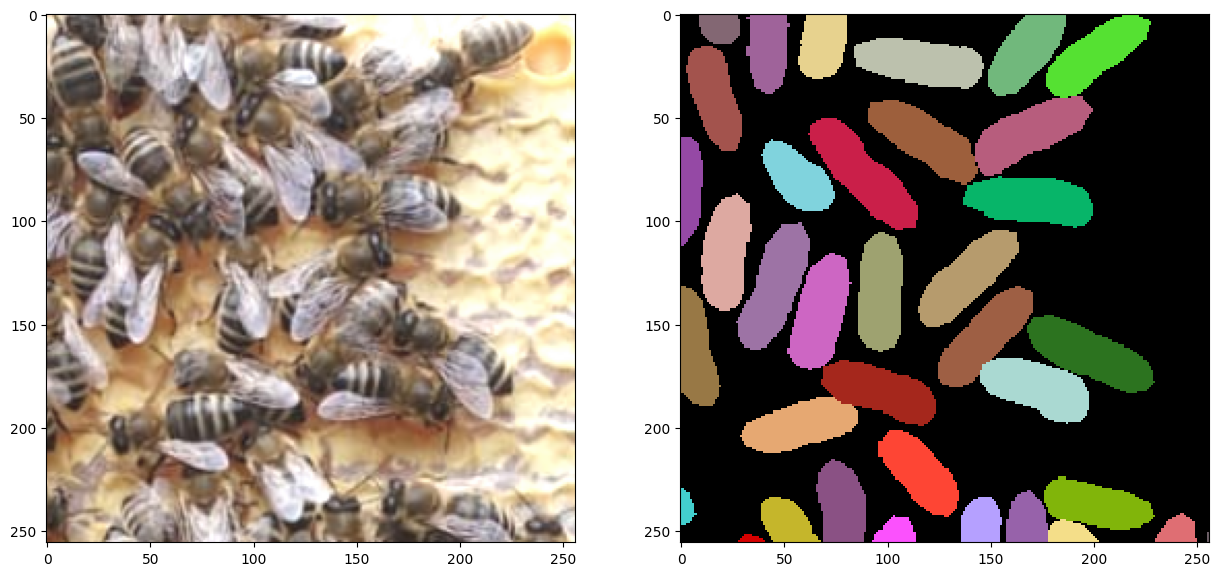

In [10]:
import numpy as np
from InstanSeg.utils.utils import show_images
import fastremap
import os
from skimage import io
from pathlib import Path

def load_custom_dataset(Segmentation_Dataset):

    #data_path = os.path.abspath("../Raw_Datasets/Nucleus_Segmentation") + "/My_Own_Dataset/"
    data_path = image_patch_path
    mask_path = label_patch_path

    if not os.path.exists(data_path):
        raise FileNotFoundError(data_path)
    items = []

    files = os.listdir(data_path)
    files = files[:30]

    for file in sorted(files):
        
        print(file)
        file = os.path.join(data_path, file)
        item = {}
        if "masks" in file:
            continue # Skip masks

        #mask_path = str(Path(file).parent / Path(file).stem) + "_masks" + Path(file).suffix
        mask_name = os.path.join(label_patch_path, Path(file).stem+'.tif')

        image = io.imread(str(file))
        masks = io.imread(mask_name)
        masks, _ = fastremap.renumber(masks, in_place=True)
        masks = fastremap.refit(masks)
        assert masks.squeeze().ndim == 2, r"The mask should be a 2D array, found {}".format(masks.shape)

        item['nucleus_masks'] = masks # The masks should be a numpy array (or pytorch tensor) with shape (H, W). The values should be integers starting from 0. Each integer represents a different object.
        # item["cell_masks"] = cell_masks # Optional

        item['image'] = image # The image should be a numpy array (or pytorch tensor) with shape (H, W, C) or shape (C, H, W). Where C is the number of channels. C must be smaller than H and W
        
        item["parent_dataset"] = "My_Own_Dataset" #Important, this is the handle to call the dataset when training. 
        item['licence'] = "TODO" #optional but recommended for sharing.


        # Pixel size should be in microns per pixel (usually it is in the range 0.2 to 1). 
        # If the segmentation task is not for cells, or the pixel size is not known, you can comment this line out. 
        # However, we strongly recommend you make sure the labels are of reasonable size, and fairly uniform across the dataset.
        # A good label area is around 300 pixels. See load_Cellpose in data_download.py for an example of how to load a dataset without pixel size.
        item['pixel_size'] = 0.25  
        item['image_modality'] = "Brightfield" # Fluorescence or Brightfield, only used for padding.
        item['file_name'] = file #optional
        items.append(item)

    assert len(items) > 0, "No items found in the dataset folder."

    np.random.seed(42) 
    np.random.shuffle(items)
    Segmentation_Dataset['Train'] += items[:int(len(items) * 0.1)]
    Segmentation_Dataset['Validation'] += items[int(len(items) * 0.8):int(len(items) * 0.9)]
    Segmentation_Dataset['Test'] += items[int(len(items) * 0.9):]

    return Segmentation_Dataset

Segmentation_Dataset = {}
Segmentation_Dataset['Train']=[]
Segmentation_Dataset['Test']=[]
Segmentation_Dataset['Validation']=[]


Segmentation_Dataset = load_custom_dataset(Segmentation_Dataset)

item = Segmentation_Dataset['Train'][-1]

show_images(item['image'],item['nucleus_masks'],colorbar = False,labels = [1], axes = True)

# Save the custom dataset.
#path = os.environ['INSTANSEG_DATASET_PATH'] 
dataset_name = os.path.join(parent_path,"custom_dataset.pth")
import torch
torch.save(Segmentation_Dataset,dataset_name)

In [11]:
type(dataset_name)

str

In [12]:
import pandas as pd

train_images, train_labels, train_meta, val_images, val_labels, val_meta = _read_images_from_pth(data_path = parent_path, dataset = 'custom_dataset.pth', data_slice = args.data_slice, dummy = args.dummy, args = args, sets= ["Train","Validation"] )

train_loader, test_loader = get_loaders(train_images, train_labels, val_images, val_labels, train_meta, val_meta, args)
    
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

if args.save:
    if not os.path.exists(args.output_path):
        os.mkdir(args.output_path)
    if not os.path.exists(os.path.join(parent_path, "epoch_outputs")):
        os.mkdir(os.path.join(parent_path,"epoch_outputs"))


pd.DataFrame.from_dict(args_dict, orient='index').to_csv( os.path.join(parent_path, 'models', "experiment_log.csv"),
                                                        header=False)

iou_threshold = np.linspace(0.5, 1.0, 10)
from torch.utils.tensorboard import SummaryWriter

if not os.path.exists(Path("../tensorboard_logs/")):
    os.mkdir(Path("../tensorboard_logs/"))

writer = SummaryWriter( Path("../tensorboard_logs/"+str(args.experiment_str)+'/gradient_monitoring'),flush_secs=10)


if args.hotstart_training > 0:
    hot_epochs = args.hotstart_training
    print("Hotstart for "+str(hot_epochs)+" epochs with binary_xloss and dice_loss")
    method.update_seed_loss("binary_xloss")
    method.update_binary_loss("dice_loss")
    #model, train_losses, test_losses, f1_list, f1_list_cells = main(model, loss_fn, train_loader, test_loader, num_epochs=hot_epochs, epoch_name='hotstart_epoch')

    print("Starting main training loop with",args.seed_loss_fn, "and", args.binary_loss_fn)
    method.update_seed_loss(args.seed_loss_fn)
    method.update_binary_loss(args.binary_loss_fn)



#model, train_losses, test_losses, f1_list, f1_list_cells = main(model, loss_fn, train_loader, test_loader, num_epochs=num_epochs)

Loading dataset from  D:\images\tnia-python-images\imagesc\2024_09_25_Intanseg_bees\custom_dataset.pth
Hotstart for 10 epochs with binary_xloss and dice_loss
Starting main training loop with l1_distance and lovasz_hinge


In [14]:
epoch_name = 'test epoch'

global best_f1_score

train_losses = []
test_losses = []

best_f1_score = -1
f1_list = []
f1_list_cells = []

num_epochs = 1000

for epoch in range(num_epochs):

    print("Epoch:", epoch)

    train_loss, train_time = train_epoch(model, device, train_loader, loss_fn, optimizer, args = args, writer = writer)

    if epoch <= 5 + 500 * (
            1 - args.on_cluster) and not args.model_folder:  # Training is just starting AND we are not loading a model
        save_epoch_outputs = True
    else:
        save_epoch_outputs = False

    test_loss, f1_score, test_time = test_epoch(model, device, test_loader, loss_fn, debug=False,
                                                best_f1=best_f1_score,
                                                save_bool=save_epoch_outputs,
                                                args = args,
                                                postprocessing_fn = method.postprocessing,
                                                method = method,
                                                iou_threshold = iou_threshold,
                                                writer = writer,
                                                save_str=str(os.path.join(parent_path, f"epoch_outputs/{epoch_name}_" + str(epoch))))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if epoch % 10 ==0 and args.optimize_hyperparameters:
        best_params = optimize_hyperparameters(model,postprocessing_fn = method.postprocessing,data_loader= test_loader,verbose = not args.on_cluster, show_progressbar = not args.on_cluster)
        method.update_hyperparameters(best_params)


    dict_to_print = {"train_loss": train_loss, "test_loss": test_loss, "training_time": int(train_time),
                        "testing_time": int(test_time)}

    if args.cells_and_nuclei:
        f1_list.append(f1_score[0])
        f1_list_cells.append(f1_score[1])
        dict_to_print["f1_score_nuclei"] = f1_score[0]
        dict_to_print["f1_score_cells"] = f1_score[1]
        f1_score = np.nanmean(f1_score)
        dict_to_print["f1_score_joint"] = f1_score

    else:
        f1_score = f1_score[0]
        f1_list.append(f1_score)
        dict_to_print["f1_score"] = f1_score

    if args.cosineannealing:
        dict_to_print["lr:"] = optimizer.param_groups[0]["lr"]
        scheduler.step()

            
    if f1_score > best_f1_score or save_epoch_outputs:
        best_f1_score = np.maximum(f1_score, best_f1_score)

        print("Saving model, best f1_score:", best_f1_score)

        torch.save({
            'f1_score': best_f1_score,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, args.output_path / "model_weights.pth") 


    print(str(dict_to_print).replace("{", "").replace("}", "").replace("'", ""))

Epoch: 0


100%|██████████| 67/67 [00:11<00:00,  5.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving model, best f1_score: 0.023640771842386443


TypeError: unsupported operand type(s) for /: 'str' and 'str'